In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import copy
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")
sb.set(rc={'figure.figsize':(15,8)})

In [2]:
# Creating datapoints with 3 cluster centers in 2D space
X,y = make_blobs(cluster_std=1.5,random_state=20,n_samples=500,centers=3)

In [3]:
# randn generates an array of shape (d0, d1, ..., dn), filled with random floats sampled from a univariate “normal” (Gaussian) distribution of mean 0 and variance 1
X = np.dot(X,np.random.RandomState(1).randn(2,2))

In [4]:
data = pd.DataFrame(X,columns=['x1','x2'])

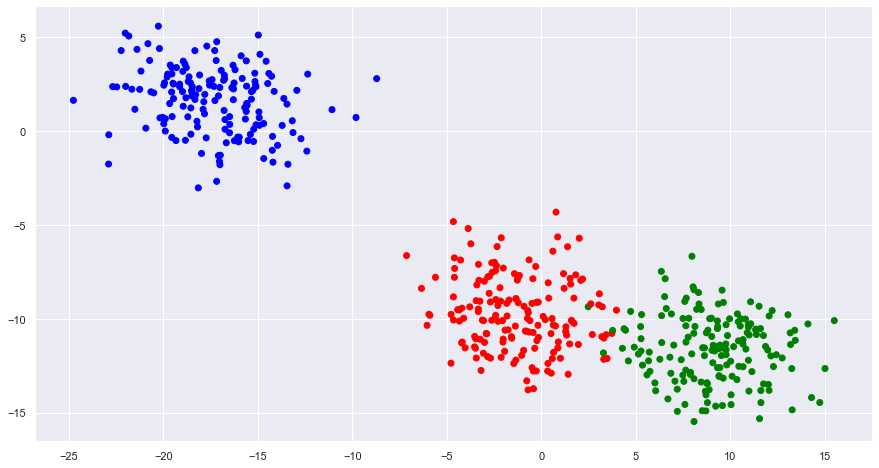

In [5]:
colors = ['red','green','blue']
plt.scatter(x=data['x1'],y=data['x2'],c=y,cmap=matplotlib.colors.ListedColormap(colors))

In [6]:
# function for calculating the denominator for posterior probabilities
def calculateDenominator(x,params,k):
    sum = 0
    for i in range(k):
        mu = np.array(params[i]['mu'+str(i)])
        mu = mu[~np.isnan(mu)]
        sum+= ((multivariate_normal.pdf(x,mean=mu,cov=params[i]['cov'+str(i)],allow_singular=True) * params[i]['prior'+str(i)]))

    return sum

In [7]:
def EM_Algorithm(data,k,eps):
    # Initialization of the parameters
    params = []
    params_old = []        # empty params list to keep track of previous means to apply early stopping

    for i in range(k):
        # np.random.seed(i*10)
        a = np.random.randint(0,len(data))
        cov = np.zeros((data.shape[1],data.shape[1]))
        np.fill_diagonal(cov,i+1)
        params.append({'mu'+str(i):np.array(data.iloc[a].values),'cov'+str(i) :cov ,'prior'+str(i):(1/k)})
    print(params)

    #expectation step :
    epsilon = 100
    x_dim = data.columns.shape[0]
    data_cols = data.columns
    iterations = 0
    while epsilon > eps:
        for i in range(k):
            col = 'w'+str(i)
            data[col] = np.nan
            mu = np.array(params[i]['mu'+str(i)])   # mean at each k value
            mu = mu[~np.isnan(mu)]           
            cov = params[i]['cov'+str(i)]             # covariance at each k value
            prior = params[i]['prior'+str(i)]          # prior at each k
            for j in range(len(data)):
                part1 = multivariate_normal.pdf(data.iloc[j][data_cols].values,mean=mu,cov=cov,allow_singular=True)
                numerator = part1*prior
                part2 = calculateDenominator(data.iloc[j][data_cols].values,params,k)
                data.loc[j][col] = (numerator/part2)

        params_old = copy.deepcopy(params)     # storing the parameters for t-1 step

        # maximization step

        for i in range(k):

            # reestimate mean
            sum1 = 0
            for j in range(len(data)):
                sum1+= data.iloc[j]['w'+str(i)] * data.iloc[j][data_cols].values
            sum2 = np.sum(data['w'+str(i)].values)
            params[i]['mu'+str(i)] = (sum1/sum2)

            # reestimate prior:
            prior = (data['w'+str(i)].values.sum()) / len(data)
            params[i]['prior'+str(i)] = prior

            # re-estimate covariance matrix:
            cov_numerator = 0
            for j in range(len(data)):
                cov_numerator += data.iloc[j]['w'+str(i)] * np.dot(data.iloc[j][data_cols].values.reshape(x_dim,1)-params[i]['mu'+str(i)].reshape(x_dim,1),(data.iloc[j][data_cols].values.reshape(x_dim,1)-params[i]['mu'+str(i)].reshape(x_dim,1)).T)
            cov_denominator = data['w'+str(i)].values.sum()
            cov = cov_numerator/cov_denominator
            params[i]['cov'+str(i)] = cov

        epsilon = 0
        for i in range(k):
            epsilon += np.linalg.norm(params[i]['mu'+str(i)].reshape(x_dim,1)-params_old[i]['mu'+str(i)].reshape(x_dim,1))  # stopping criteria
    return data

In [8]:
data = EM_Algorithm(data,3,1e-3)
# printing the intialization parameters
# error allowed for the clustering is 0.1%

[{'mu0': array([ 11.97839616, -11.6635671 ]), 'cov0': array([[1., 0.],
       [0., 1.]]), 'prior0': 0.3333333333333333}, {'mu1': array([-15.33250898,   2.08739011]), 'cov1': array([[2., 0.],
       [0., 2.]]), 'prior1': 0.3333333333333333}, {'mu2': array([ 10.45115981, -12.52919059]), 'cov2': array([[3., 0.],
       [0., 3.]]), 'prior2': 0.3333333333333333}]


In [9]:
# Assigning hard classes after the complettion of all iterations or the early stopping
data['y'] = np.nan
for i in range(len(data)):
    data['y'].loc[i] = np.argmax(list(zip(data[['w0','w1','w2']].loc[i])))

In [10]:
output = data[['x1','x2','y']]

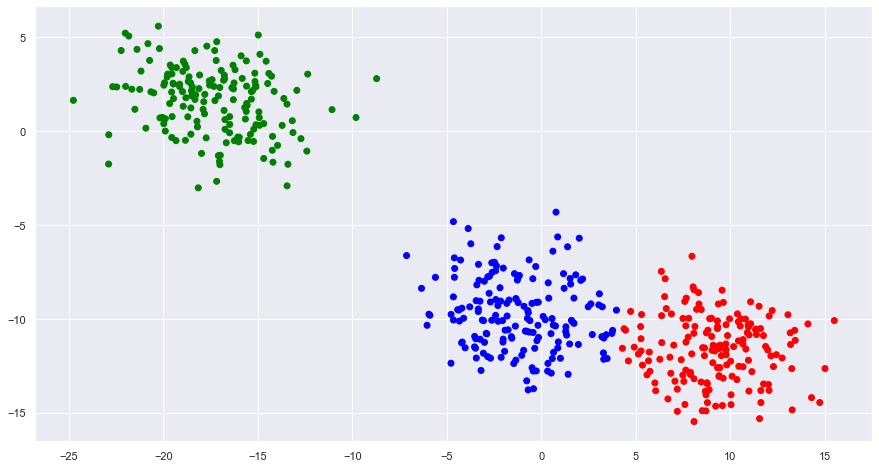

In [11]:
colors = ['red','green','blue']
plt.scatter(x=output['x1'],y=output['x2'],c=output['y'],cmap=matplotlib.colors.ListedColormap(colors))
# with the error allowed 3 points are being allocated to another distribution based on maximum likelihood.